## Harmonic oscillator simulation with and without order-compensating coordinate transformation: convergence analysis

Symplectic Euler method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, newton

In [2]:
from tqdm import tqdm

In [3]:
import matplotlib as mpl
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """ This function draws slopes or "convergence triangles" into loglog plots.

    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    width = x2 - x1
    log_offset = y1 / (x1 ** slope)

    y2 = log_offset * ((x1 + width) ** slope)
    height = y2 - y1

    a = origin
    b = corner
    c = [x2, y2]

    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    va_xlabel = "top" if not inverted else "bottom"
    ha_ylabel = "left" if not inverted else "right"

    offset_xlabel = [0.0, -0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, 0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)

In [4]:
fig_width_mm = 80
fig_width_wide_mm = 180
mm_to_in = 0.03937

dpi = 600

linewidth = 0.7

In [5]:
font_size = 9
smaller_font_size = 0.8*font_size

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": font_size,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.constrained_layout.use": True 
    }
)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm} \usepackage[utf8]{inputenc}')

In [6]:
q0 = 1
p0 = 0

def H(q,p):
    return 1/2 * p**2 + 1/2 * q**2

def H_q(q,p):
    return q

def H_p(q,p):
    return p

def exact_solution(t):
    return np.array(
        [
            np.cos(t),
            -np.sin(t),
        ]
    )

In [7]:
def qm(q):
    return q / (1 + k*h**2)
    
def Q(q):
    qhat = qm(q)
    return 2 / np.pi * ( qhat * np.sqrt(1 - qhat**2) + np.arcsin(qhat) )
    
def dQdq(q):
    return 4 / np.pi * np.sqrt(1 - (q**2)/(1 + h**2*k)**2) / (1 + h**2 * k)

def d2Qdq2(q):
    return - 4 / np.pi * q / (1 + h**2 * k)**3 / np.sqrt(1 - q**2 / (1 + h**2 * k)**2)

def Qinv(qbar):
    return newton(lambda q: Q(q) - qbar, x0=0, fprime=dQdq)

def dQinvdqbar(qbar):
    return 1/(dQdq(Qinv(qbar)))

def P(q, p):
    return p * (dQinvdqbar(Q(q)))

def Pinv(qbar, pbar):
    return pbar * (dQdq(Qinv(qbar)))

def Hbar(qbar, pbar):
    return 1/2 * Pinv(qbar, pbar)**2 + 1/2 * Qinv(qbar)**2

def Hbar_qbar(qbar, pbar):
    return pbar**2 * (dQdq(Qinv(qbar))) * d2Qdq2(Qinv(qbar)) * dQinvdqbar(qbar) + Qinv(qbar) * dQinvdqbar(qbar)
 
def Hbar_pbar(qbar, pbar):
    return pbar * (dQdq(Qinv(qbar)))**2

In [8]:
timesteps = []
Herrors = []
Herrors_bar = []
l2errors = []
l2errors_bar = []

for n in range(9):
    print('----')
    t_max = 8
    
    h = 0.2 / ((2)**n)
    J = int(np.floor(t_max / h))
    t = np.array(range(0, J+1))*h
    
    print(t[-1], t_max)
    
    q = np.zeros(J+1)
    p = np.zeros(J+1)
    
    q[0] = q0
    p[0] = p0
    
    for j in range(0, J):
        p[j+1] = p[j] - h*H_q(q[j], None)
        q[j+1] = q[j] + h*H_p(None, p[j+1])
    
    # k = 1.5
    k = 2
    
    qbar = np.zeros(J+1)
    pbar = np.zeros(J+1)
    
    qbar[0] = Q(q0)
    pbar[0] = P(q0, p0)
    
    print(qbar[0], pbar[0])
    
    for j in tqdm(range(0, J)):
        pbar[j+1] = root_scalar(
            lambda pbarjp1: np.real(pbar[j] - h*Hbar_qbar(qbar[j], pbarjp1) - pbarjp1),
            x0=np.real(pbar[j]),
        ).root
        qbar[j+1] = qbar[j] + h*Hbar_pbar(qbar[j], pbar[j+1])
    
    qbarlast, pbarlast = qbar[-1], pbar[-1]
    qbarinvlast, pbarinvlast = Qinv(qbarlast), Pinv(qbarlast, pbarlast)
    qlast, plast = q[-1], p[-1]
    
    Hlast = H(qlast, plast)
    Hbarlast = Hbar(qbarlast, pbarlast)
    
    Hexact = 1/2

    print(Hlast, Hbarlast, H(qbarinvlast, pbarinvlast))
    print(len(qbar), len(q), len(t))

    timesteps.append(h)
    Herrors.append(np.abs(Hlast - Hexact))
    Herrors_bar.append(np.abs(Hbarlast - Hexact))
    
    qexact, pexact = exact_solution(t[-1])
    l2errors.append(np.sqrt((qexact - qlast)**2 + (pexact - plast)**2))
    l2errors_bar.append(np.sqrt((qexact - qbarinvlast)**2 + (pexact - pbarinvlast)**2))

----
8.0 8
0.9760697104461662 0.0


100%|██████████| 40/40 [00:00<00:00, 59.69it/s]


0.5255979510778651 0.5031608206980784 0.5031608206980784
41 41 41
----
8.0 8
0.9967137763032492 0.0


100%|██████████| 80/80 [00:00<00:00, 82.11it/s]


0.5098171977007816 0.5008394180713572 0.5008394180713572
81 81 81
----
8.0 8
0.9995790646436641 0.0


100%|██████████| 160/160 [00:01<00:00, 102.42it/s]


0.504231875368508 0.5002099840232607 0.5002099840232607
161 161 161
----
8.0 8
0.9999470575862165 0.0


100%|██████████| 320/320 [00:02<00:00, 128.64it/s]


0.5019549871096309 0.5000532186042396 0.5000532186042396
321 321 321
----
8.0 8
0.9999933719619345 0.0


100%|██████████| 640/640 [00:04<00:00, 139.46it/s]


0.5009382636265983 0.5000130296375047 0.5000130296375047
641 641 641
----
8.0 8
0.9999991711748493 0.0


100%|██████████| 1280/1280 [00:08<00:00, 147.43it/s]


0.5004594490372261 0.5000032399483291 0.5000032399483291
1281 1281 1281
----
8.0 8
0.9999998963868376 0.0


100%|██████████| 2560/2560 [00:16<00:00, 154.48it/s]


0.5002273193362188 0.5000008049225274 0.5000008049225274
2561 2561 2561
----
8.0 8
0.9999999870480449 0.0


100%|██████████| 5120/5120 [00:32<00:00, 158.46it/s]


0.5001130603067392 0.5000002003631152 0.5000002003631152
5121 5121 5121
----
8.0 8
0.9999999983809897 0.0


100%|██████████| 10240/10240 [00:54<00:00, 188.85it/s]

0.5000563805545125 0.5000000514778978 0.5000000514778978
10241 10241 10241


In [9]:
graph_folder = '.'

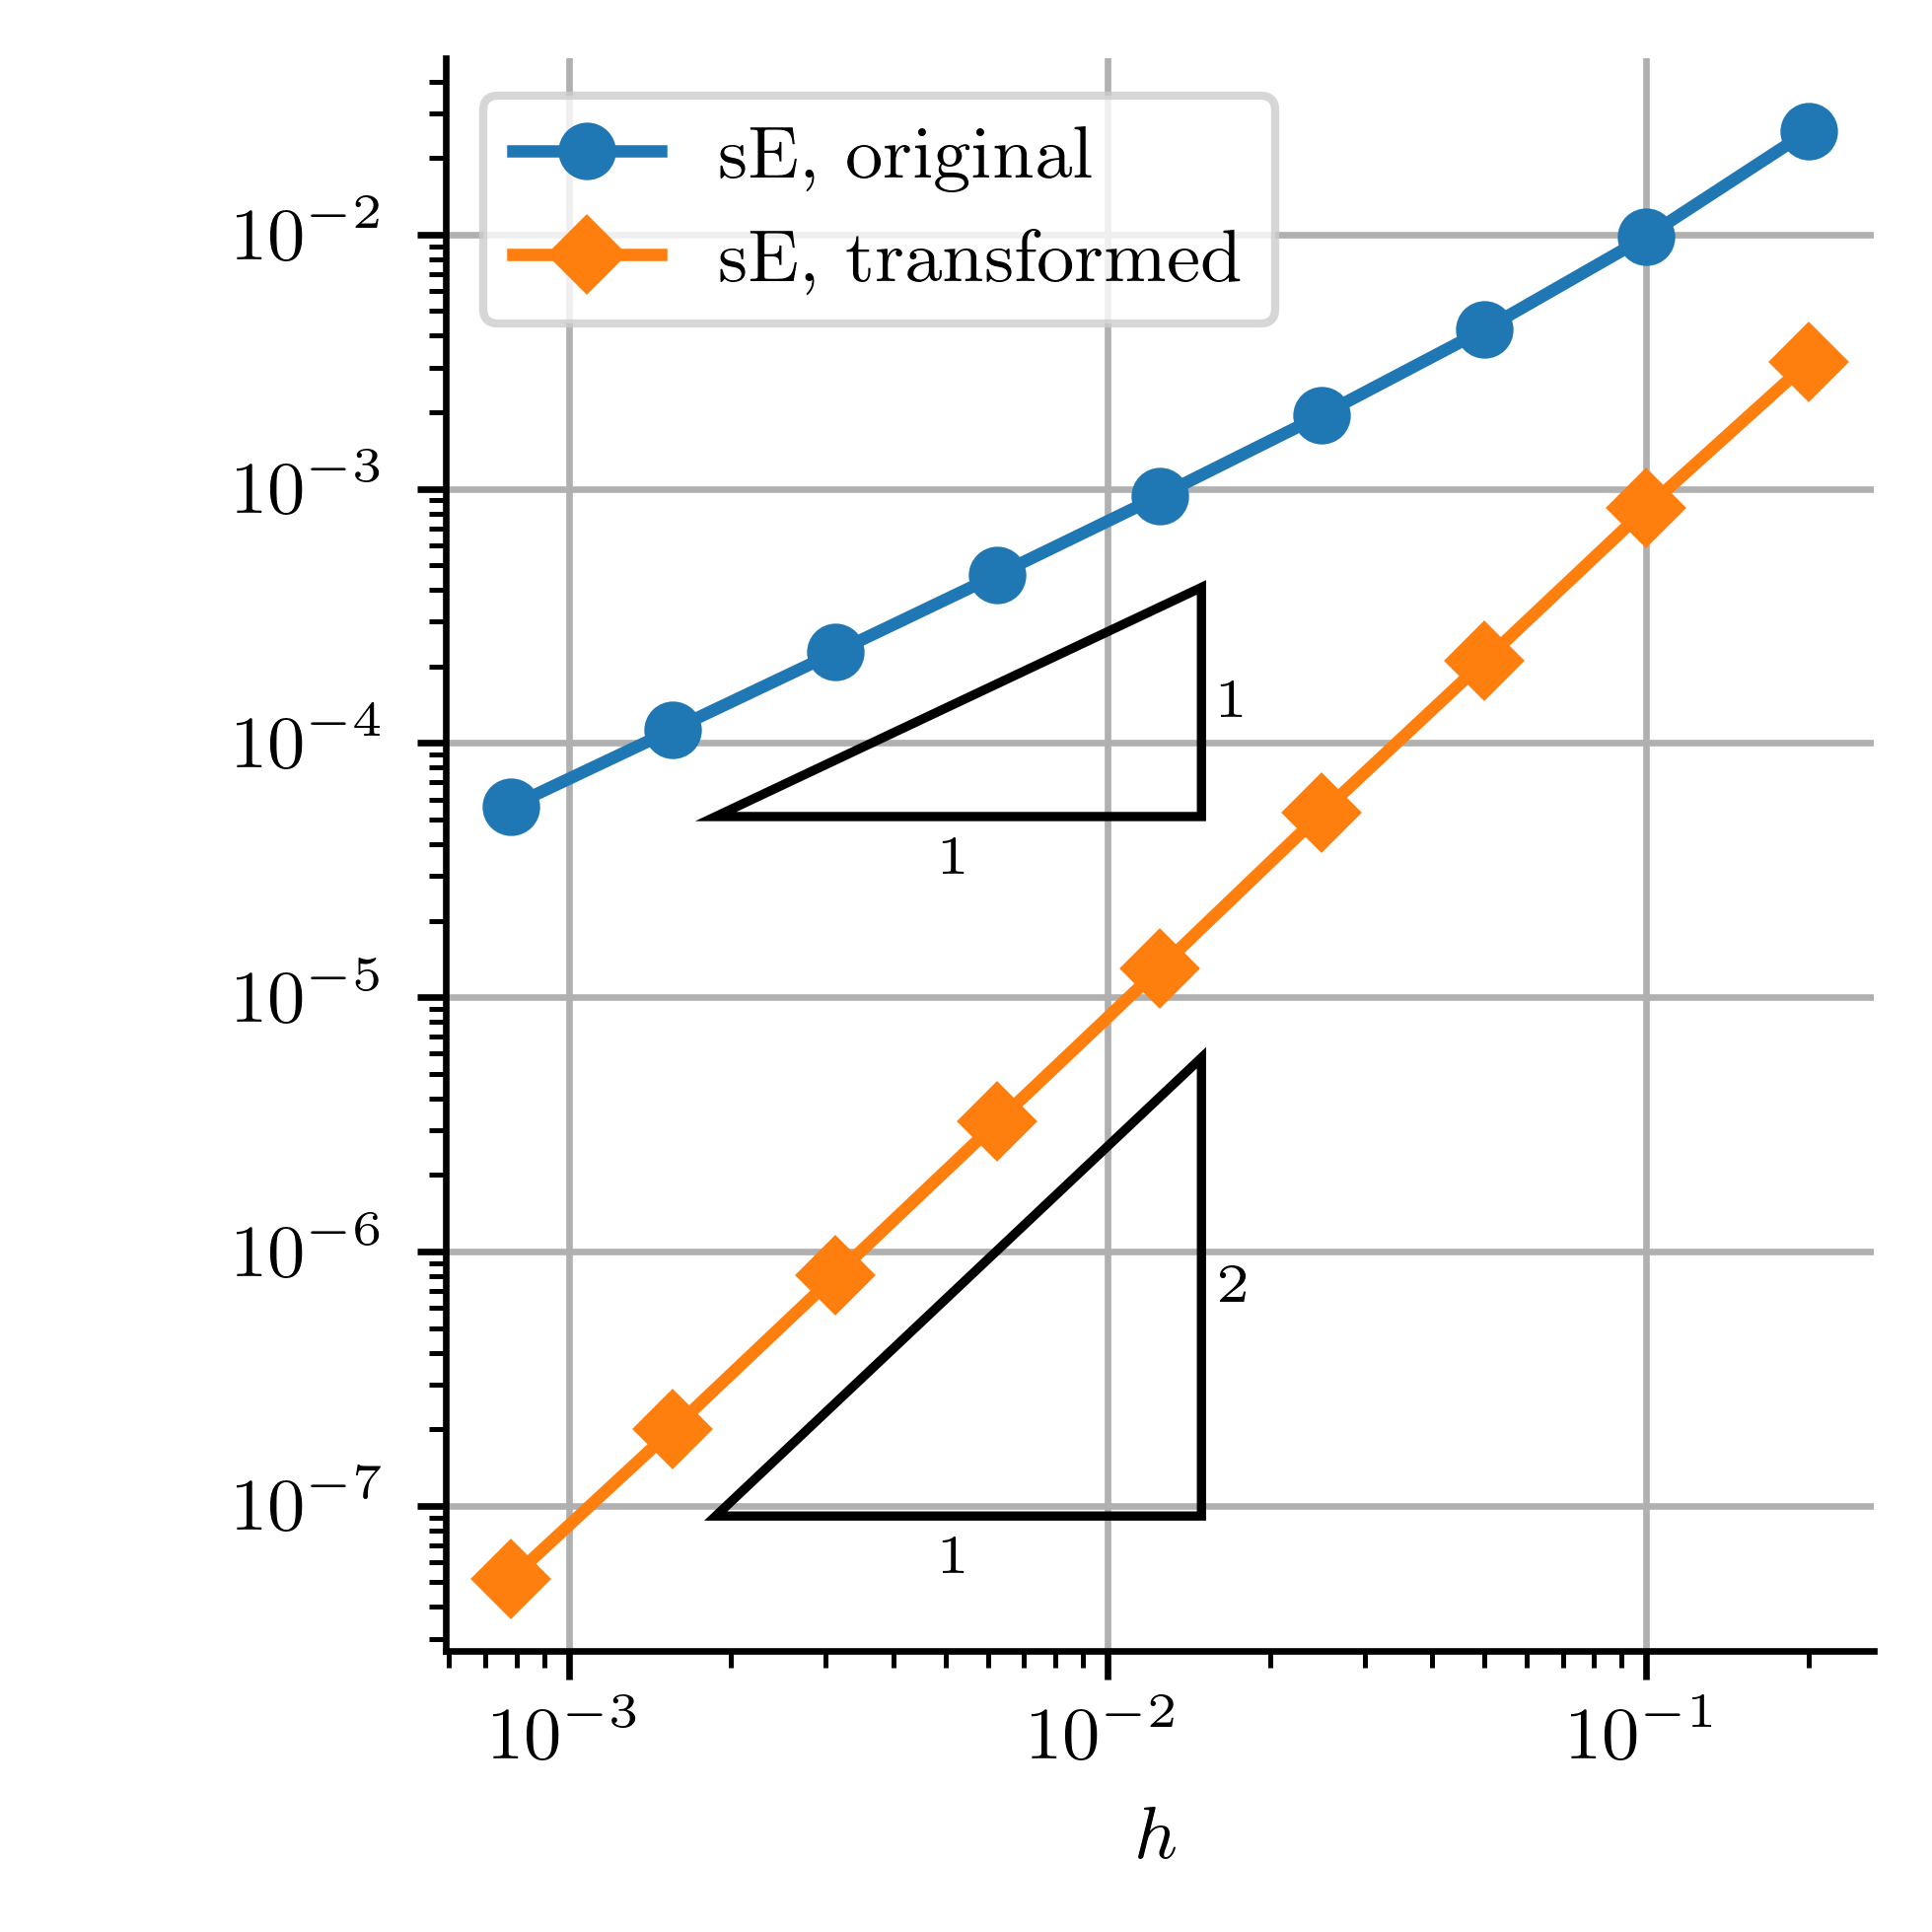

In [12]:
fig, ax = plt.subplots(figsize=(fig_width_mm*mm_to_in, fig_width_mm*mm_to_in), dpi=dpi)

ax.loglog(
    timesteps,
    Herrors,
    marker='o',
    label='sE, original',
)
ax.loglog(
    timesteps,
    Herrors_bar,
    marker='D',
    label='sE, transformed',
)

draw_loglog_slope(fig, ax, (1.2*timesteps[-2], 1/2.2 * Herrors[-2]), width_inches=2, slope=1, color='k', inverted=False)
draw_loglog_slope(fig, ax, (1.2*timesteps[-2], 1/2.2 * Herrors_bar[-2]), width_inches=2, slope=2, color='k', inverted=False)

ax.grid()

ax.set_xlabel(r'$$h$$')
ax.set_ylabel(r'absolute error of $$H$$')

ax.legend(loc='upper left')

plt.savefig(graph_folder + '/harmonic_oscillator_transformed_convergence.png', bbox_inches='tight', facecolor='white')
plt.show()